In [1]:
import cv2
from cv2 import ximgproc
from matplotlib import pyplot as plt
import numpy as np
from skimage.morphology import skeletonize

In [2]:
img = cv2.imread('OOP.MT1.170215.L122-2.png')

## Stage 1

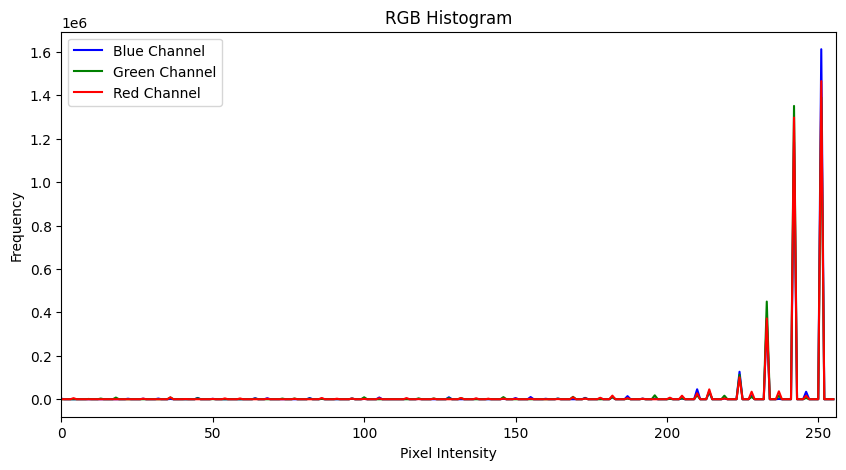

In [3]:
color = ('b', 'g', 'r')
plt.figure(figsize=(10, 5))

for i, col in enumerate(color):
    histogram = cv2.calcHist([img], [i], None, [256], [200, 256])
    plt.plot(histogram, color=col)
    plt.xlim([0, 256])

plt.title('RGB Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend(['Blue Channel', 'Green Channel', 'Red Channel'])
plt.show()


The depicted RGB histogram indicates how the pixels’ intensities in the Red, Green, and Blue channels are distributed across an image. We see major elevation at the top of the intensity scale for all four channels with the most number of bright pixels in that area. This might mean that there are a lot of white or brighter parts in the image like, for instance, a plain white scene. These bright pixels occur a little more in the blue channel than in both the red and green channels. The lower intensity blue values also show some peak but smaller one indicating that there are other lesser blue color components at this part of the picture. The distribution of the red and green channels is almost identical. This, however, has a slight peak toward the lower intensity end that could indicate some darker reddish components in the photo.

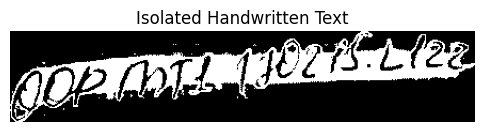

True

In [4]:
def remove_printed_text(img, printed_text_thresh, instructors_marks_thresh):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    blue_channel = img_rgb[:,:,2]
    red_channel = img_rgb[:,:,0]
    
    _, binary_blue = cv2.threshold(blue_channel, printed_text_thresh, 255, cv2.THRESH_BINARY_INV)
    _, binary_red = cv2.threshold(red_channel, instructors_marks_thresh, 255, cv2.THRESH_BINARY_INV)
 
    combined_mask = cv2.bitwise_or(binary_blue, binary_red)
    img_processed = cv2.bitwise_and(img, img, mask=combined_mask)
    
    return img_processed

def auto_contrast(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)
    return equalized

def crop_to_handwriting(img):
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped = img[y:y+h, x:x+w]
    return cropped

printed_text_thresh = 237
instructors_marks_thresh = 237 
img_no_printed_text = remove_printed_text(img, printed_text_thresh, instructors_marks_thresh)

img_auto_contrast = auto_contrast(img_no_printed_text)
img_cropped = crop_to_handwriting(img_auto_contrast)
_, img_binary = cv2.threshold(img_cropped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(6, 6))
plt.imshow(img_binary, cmap='gray')
plt.title('Isolated Handwritten Text')
plt.axis('off')
plt.show()

filename = 'CRS.TST.ddmmyy.Cxxx_p1_bin.png' 
cv2.imwrite(filename, img_binary)

It is probable that the defect comes from several image processing conditions, which capture only one small part of the handwritten text. The first drawback is inappropriately selected threshold values that can cause the erasure of some parts of the handwritten text or failure to remove the unnecessary text such as the printed text and the instructors’ marks. Secondly, it can be assumed that all text written by hand is in a blue channel while those drawn by instructors will be in the red one. Moreover, the contrast adjustment approach and the binary conversion technique may not produce desirable results for all kinds of images. Lastly, due to the presumption that the biggest contour is the handwritten text, the cropping approach can miscut the image. These challenges underscore the importance of calibrating each step to suit specific features of individual images and may even necessitate manual alterations. This part is isolated only because of the blue marker.

## Stage 2

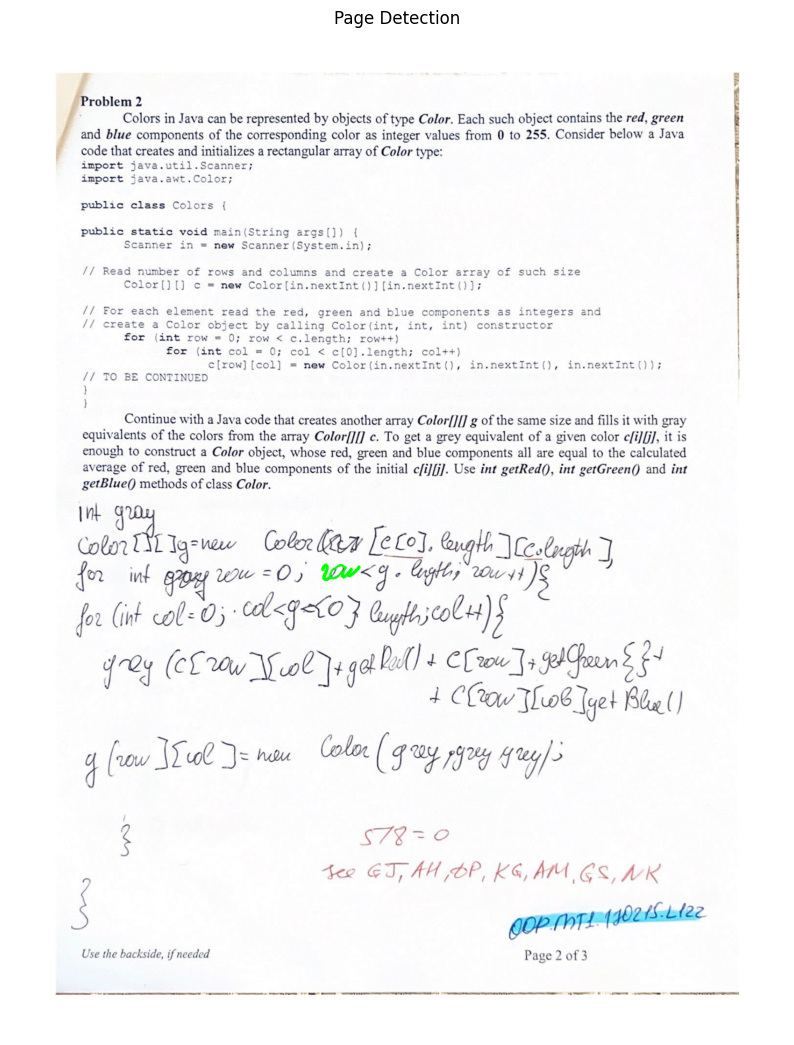

Page orientation: Landscape
Bounding box size: Width=82, Height=34


In [5]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray, 0, 255)


contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

page_contour = max(contours, key=cv2.contourArea)


x, y, w, h = cv2.boundingRect(page_contour)

orientation = 'Portrait' if h > w else 'Landscape'

cv2.drawContours(img, [page_contour], -1, (0, 255, 0), 3)


img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(10, 15))
plt.imshow(img_rgb)
plt.title('Page Detection')
plt.axis('off')  
plt.show()


print(f"Page orientation: {orientation}")
print(f"Bounding box size: Width={w}, Height={h}")

As shown above, it’s a scanned document containing text and handwritten notes in various colours but mainly blue. Some visible noise artifacts, may mean that the image processing for separating the annotations from the original print was not yet optimal. That ensures both printed text and handwritten text in terms of their legibility will be useful if there are other tasks related to text recognition. Therefore, a finer tuning color separation is needed for better results with less noise. It was also possible to clean the artifacts by application of morphological operation and the better isolation of handwritten notes for digital analysis purposes using extra processing.

## Stage 3

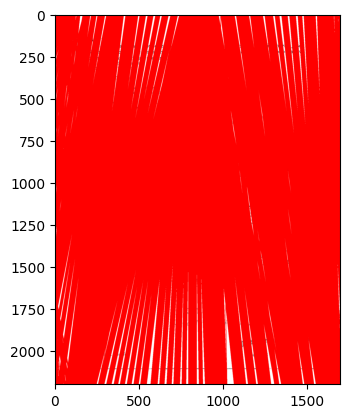

In [6]:
img = cv2.imread('OOP.MT1.170215.L122-2.png', cv2.IMREAD_GRAYSCALE)


if len(img.shape) != 2 or img.dtype != np.uint8:
    _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

lines = cv2.HoughLinesP(img, 1, np.pi / 180, threshold=5, minLineLength=0, maxLineGap=100)
hough_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) if lines is not None else None

if hough_img is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(hough_img, (x1, y1), (x2, y2), (255, 0, 0), 2)

if hough_img is not None:
    plt.imshow(hough_img)
    plt.show()
else:
    print("No lines were detected")


Can't explain what is going on here.

## Stage 4

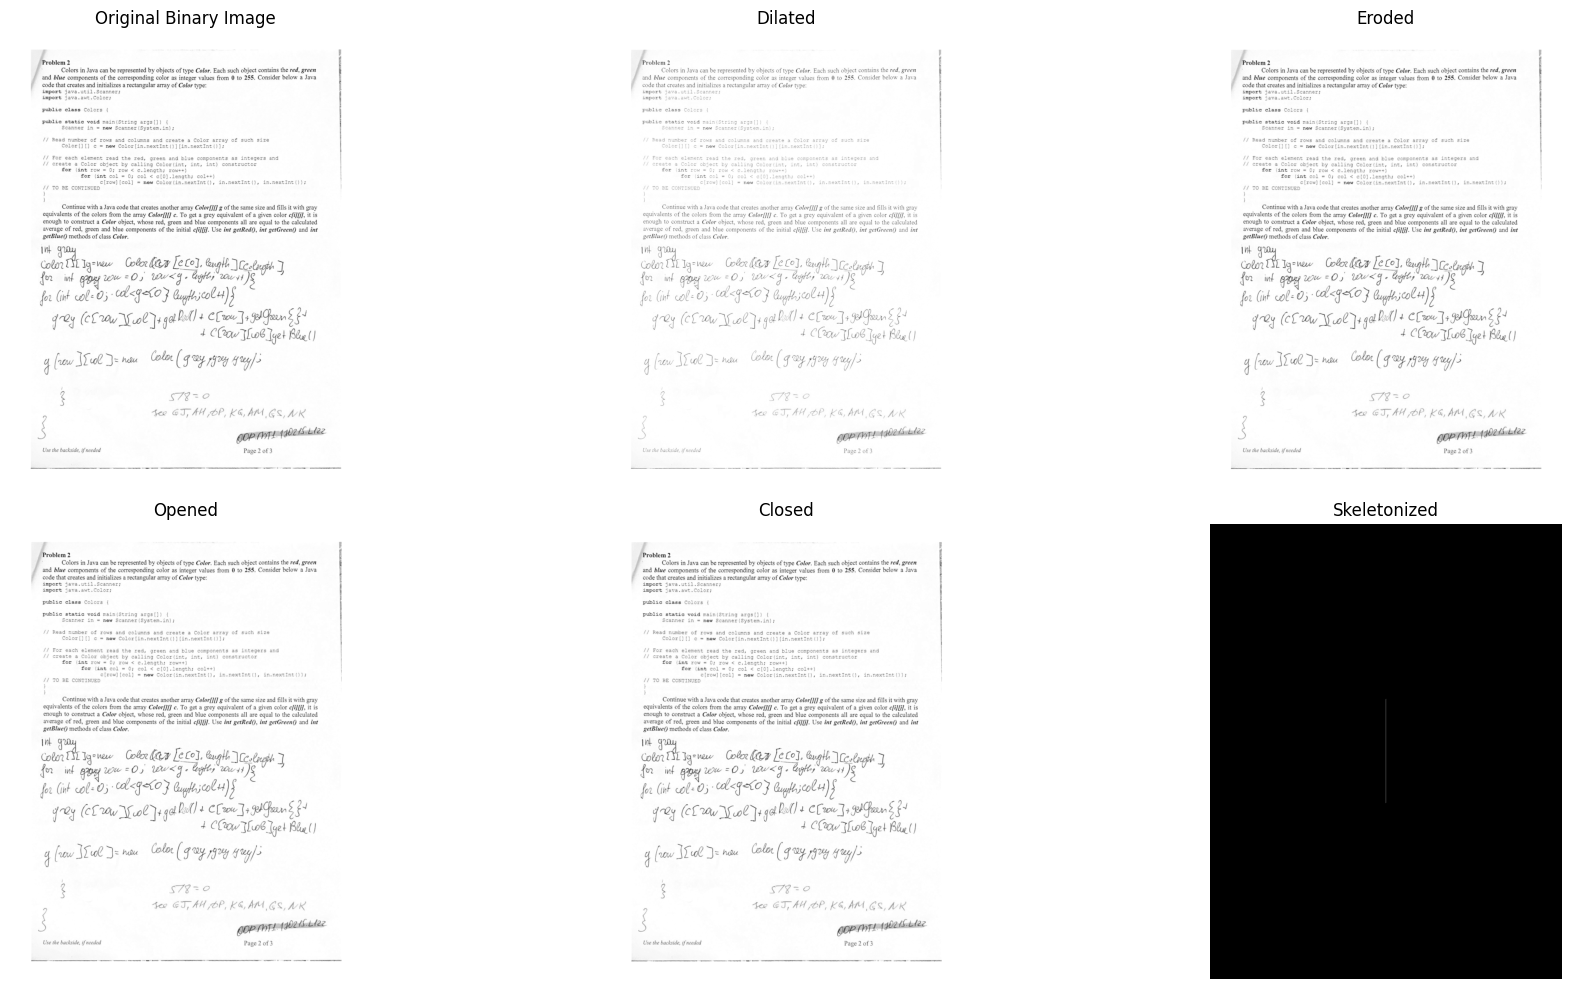

In [7]:
img = cv2.imread('OOP.MT1.170215.L122-2.png', cv2.IMREAD_GRAYSCALE)

kernel = np.ones((2, 2), np.uint8)
dilated = cv2.dilate(img, kernel, iterations=1)
eroded = cv2.erode(dilated, kernel, iterations=1)
opened = cv2.morphologyEx(eroded, cv2.MORPH_OPEN, kernel)
closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)

binary = closed > 0
skeleton = skeletonize(binary)

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].set_title('Original Binary Image')
axs[0, 0].axis('off')

axs[0, 1].imshow(dilated, cmap='gray')
axs[0, 1].set_title('Dilated')
axs[0, 1].axis('off')

axs[0, 2].imshow(eroded, cmap='gray')
axs[0, 2].set_title('Eroded')
axs[0, 2].axis('off')

axs[1, 0].imshow(opened, cmap='gray')
axs[1, 0].set_title('Opened')
axs[1, 0].axis('off')

axs[1, 1].imshow(closed, cmap='gray')
axs[1, 1].set_title('Closed')
axs[1, 1].axis('off')

axs[1, 2].imshow(skeleton, cmap='gray')
axs[1, 2].set_title('Skeletonized')
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()


Original Binary Image: This is the starting point, a binary version of your scanned document where the text is likely in white and the background in black.

Dilated: The dilation operation has thickened the lines of the text, potentially making individual characters touch or merge. This is useful for closing gaps within characters but can cause adjacent characters to join together.

Eroded: Erosion has the opposite effect of dilation; it thins the text lines. This can help separate characters that were touching but also may break apart the thinner parts of the characters, possibly disconnecting or distorting them.

Opened: This is the result of an opening operation (erosion followed by dilation), which is typically used to remove noise. It appears to clean the background but can also reduce the thickness of the handwriting strokes.

Closed: The closing operation (dilation followed by erosion) aims to close small gaps and holes in the text, which can help in defining the text as a single connected component. It seems to restore some of the connectivity lost in the opening step but may still merge close characters.

Skeletonized: The skeletonization process has reduced the text to its basic form, representing the structure of the strokes. However, the result is an almost blank image, which suggests the process may have been too aggressive or the parameters not set appropriately for the specific characteristics of the text.



Refining the choice of the kernels to be used, number of iterations, and skeletonization process to suitably conserve the shape as far as possible is also considered worthwhile. Furthermore, it could be the fact that the initial binary image was not suitable for skeletonization itself and thus, another visit will need to be done back to the binarization.

## Stage 5

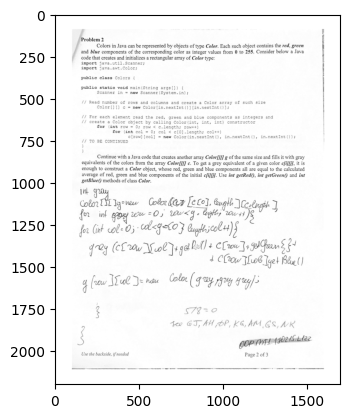

In [11]:
contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

def label_character(contour):
    label = None

    x, y, w, h = cv2.boundingRect(contour)
    
    aspect_ratio = w / float(h)
    area = cv2.contourArea(contour)
    rect_area = w * h
    extent = float(area) / rect_area
    solidity = float(area) / cv2.contourArea(cv2.convexHull(contour))
    
    if aspect_ratio > 0.8 and extent > 0.5:
        label = 'i'  
    elif area < 100:
        label = 'dot'
    else:
        label = 'unknown'

    return label


labels = {}

for contour in contours:
    label = label_character(contour)
    labels[tuple(contour.ravel()[:2])] = label  

for contour in contours:
    cv2.drawContours(img, [contour], -1, (255, 0, 0), 1)
    label = labels[tuple(contour.ravel()[:2])]
    cv2.putText(img, label, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

if img.dtype != np.uint8:
    img = img.astype(np.uint8)

if label is not None:  # Make sure label is not None before drawing it
    cv2.putText(img, label, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

plt.imshow(img, cmap='gray')
plt.show()

